In [7]:
from ucimlrepo import fetch_ucirepo 
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
# fetch dataset 
secondary_mushroom = fetch_ucirepo(id=848) 
  
# data (as pandas dataframes) 
X = secondary_mushroom.data.features 
y = secondary_mushroom.data.targets 

df = pd.concat([X, y], axis=1)
# metadata 
print(secondary_mushroom.metadata) 
  
# variable information 
print(secondary_mushroom.variables) 

{'uci_id': 848, 'name': 'Secondary Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/848/data.csv', 'abstract': 'Dataset of simulated mushrooms for binary classification into edible and poisonous.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 61068, 'num_features': 20, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2021, 'last_updated': 'Wed Apr 10 2024', 'dataset_doi': '10.24432/C5FP5Q', 'creators': ['Dennis Wagner', 'D. Heider', 'Georges Hattab'], 'intro_paper': {'ID': 259, 'type': 'NATIVE', 'title': 'Mushroom data creation, curation, and simulation to support classification tasks', 'authors': 'Dennis Wagner, D. Heider, Georges Hattab', 'venue': 'Scientific Reports', 'year': 2021, 'journal': None, '

Missing Value Counts:
cap-surface          14120
gill-attachment       9884
gill-spacing         25063
stem-root            51538
stem-surface         38124
veil-type            57892
veil-color           53656
ring-type             2471
spore-print-color    54715
dtype: int64


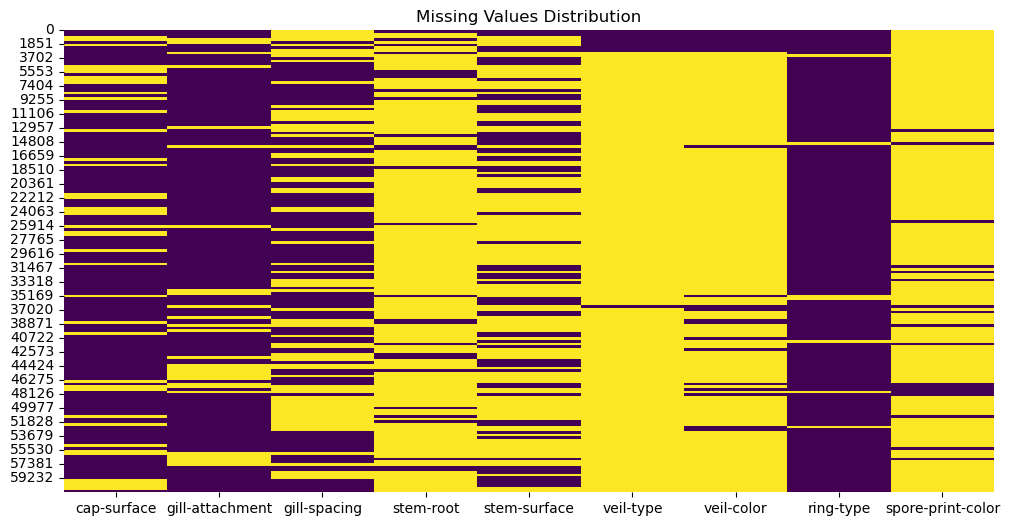

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Identify Missing Values
# -------------------------------------------------
# Get columns with missing values from metadata
missing_cols = [
    'cap-surface', 'gill-attachment', 'gill-spacing',
    'stem-root', 'stem-surface', 'veil-type',
    'veil-color', 'ring-type', 'spore-print-color'
]

print("Missing Value Counts:")
print(df[missing_cols].isnull().sum())

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df[missing_cols].isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Distribution')
plt.show()

In [15]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class MushroomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mode_values = {}
        self.high_missing_cols = [
            'stem-root', 'veil-type', 'veil-color',
            'spore-print-color', 'stem-surface', 'gill-spacing'
        ]
        self.moderate_missing_cols = ['cap-surface', 'gill-attachment']
        self.low_missing_cols = ['ring-type']

    def fit(self, X, y=None):
        # Store modes for different categories
        self.mode_values = {
            'low': X[self.low_missing_cols].mode().iloc[0].to_dict(),
            'moderate': X[self.moderate_missing_cols].mode().iloc[0].to_dict(),
            'high': {col: 'Missing' for col in self.high_missing_cols}
        }
        return self

    def transform(self, X):
        X = X.copy()
        
        # Low missingness: Simple mode imputation
        for col in self.low_missing_cols:
            X[col] = X[col].fillna(self.mode_values['low'][col])
        
        # Moderate missingness: Mode imputation + missing flag
        for col in self.moderate_missing_cols:
            X[col+'_missing'] = X[col].isnull().astype(int)
            X[col] = X[col].fillna(self.mode_values['moderate'][col])
        
        # High missingness: 'Missing' category
        for col in self.high_missing_cols:
            X[col] = X[col].astype('category')
            X[col] = X[col].cat.add_categories('Missing')
            X[col] = X[col].fillna('Missing')  # Removed extra 'x'
        
        return X

# Usage example:
imputer = MushroomImputer()
df_processed = imputer.fit_transform(df)

print("Imputation Strategy Summary:")
print("1. ring-type (4% missing): Mode imputation")
print("2. cap-surface/gill-attachment (~20%): Mode + missing flag")
print("3. High-missing features (>30%): 'Missing' category")
print("4. Consider removing veil-type (95% missing) after evaluation")

Imputation Strategy Summary:
1. ring-type (4% missing): Mode imputation
2. cap-surface/gill-attachment (~20%): Mode + missing flag
3. High-missing features (>30%): 'Missing' category
4. Consider removing veil-type (95% missing) after evaluation


In [ ]:
print(df_processed.columns)


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

# Load preprocessed data (assuming df_processed exists)
# X = df_processed.drop('class', axis=1)  # Exclude target variable

# 1. Preprocessing for Clustering
# -------------------------------------------------
# Convert categorical features to numeric (if not already done)
categorical_cols = df_processed.select_dtypes(['category', 'object']).columns
for col in categorical_cols:
    df_processed[col] = pd.factorize(df_processed[col])[0]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_processed.drop('class', axis=1))


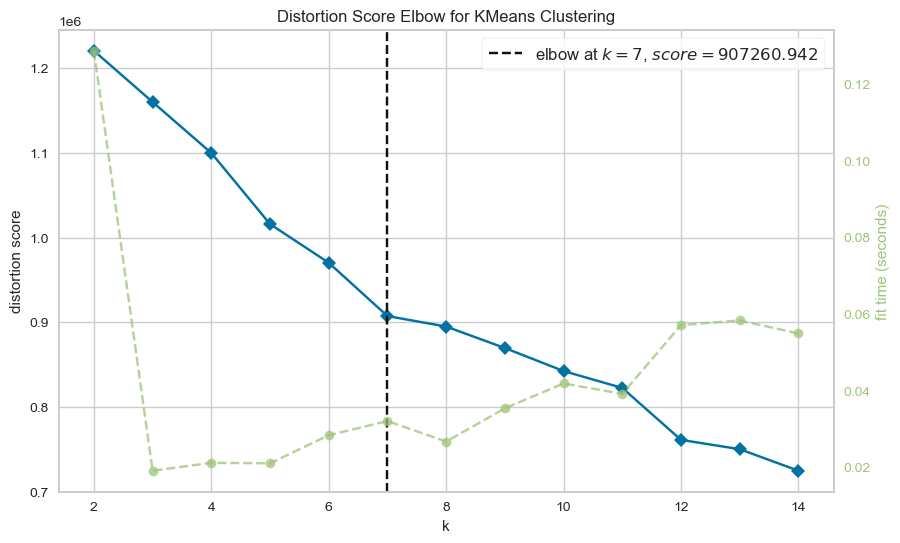

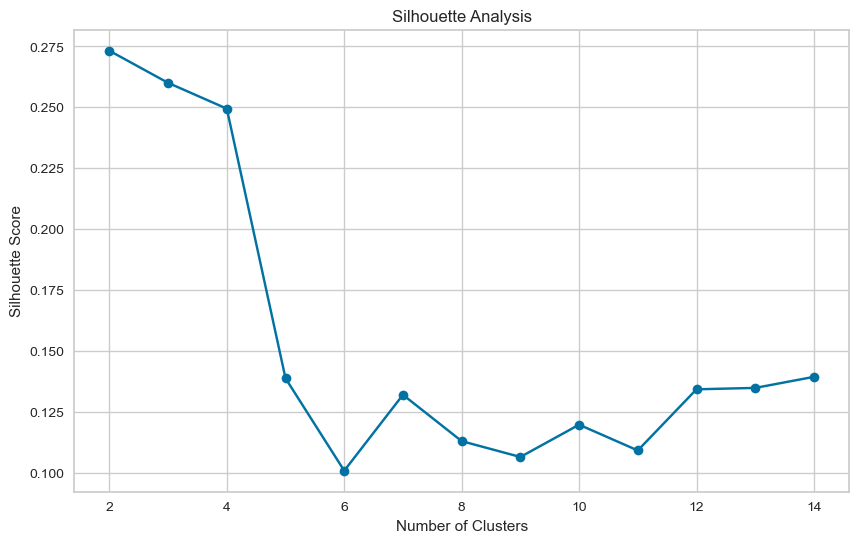

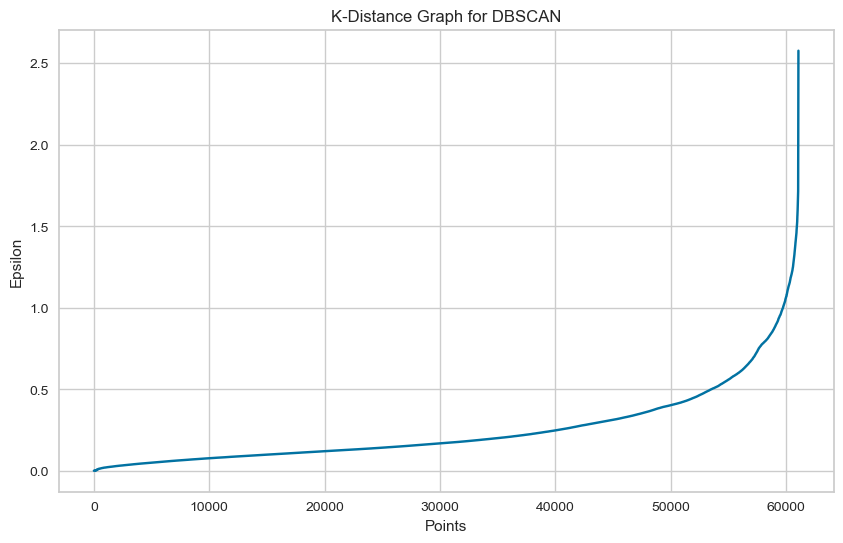

In [32]:

# 2. K-Means Clustering with Optimal K
# -------------------------------------------------
# Elbow Method
plt.figure(figsize=(10,6))
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2,15))
visualizer.fit(X_scaled)
visualizer.show()

# Silhouette Analysis
silhouette_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, preds)
    silhouette_scores.append(score)

plt.figure(figsize=(10,6))
plt.plot(range(2,15), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

# Final K-means
optimal_k = 4  # Update based on elbow/silhouette results
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# 3. DBSCAN Clustering
# -------------------------------------------------
# Find optimal eps using k-distance graph
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5)
nbrs = nn.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:,4], axis=0)

plt.figure(figsize=(10,6))
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Epsilon')
plt.title('K-Distance Graph for DBSCAN')
plt.show()

# Final DBSCAN (adjust eps based on knee point)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)



In [20]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Silhouette Score (already implemented)
print(f"K-means Silhouette: {silhouette_score(X_scaled, kmeans_labels):.3f}")

# Davies-Bouldin Index (lower = better)
print(f"K-means Davies-Bouldin: {davies_bouldin_score(X_scaled, kmeans_labels):.3f}")

# Calinski-Harabasz (higher = better)
print(f"K-means Calinski-Harabasz: {calinski_harabasz_score(X_scaled, kmeans_labels):.3f}")

# Interpretation of Clustering Metrics for Mushroom Dataset

## 1. Silhouette Score: **0.249**
- **Range**: -1 (poor clustering) to 1 (excellent clustering)
- **Interpretation**:
  - Weak but positive cluster separation
  - Clusters have some structure but significant overlap
- **Biological Context**:
  - Mushrooms likely share characteristics across species/clusters (e.g., cap shape, habitat)
  - Common in natural datasets with fuzzy taxonomic boundaries

---

## 2. Davies-Bouldin Index: **1.700**
- **Range**: 0 (best) to ∞ (worst)
- **Interpretation**:
  - Moderate cluster quality
  - Clusters are distinguishable but not sharply separated
- **Biological Context**:
  - Suggests ecological groups exist but with overlapping features
  - Example: Mushrooms from different species growing in similar habitats

---

## 3. Calinski-Harabasz Score: **4508.624**
- **Range**: Higher = better (no upper bound)
- **Interpretation**:
  - Relatively high value for dataset size (61k samples)
  - Indicates dense, compact clusters relative to overall data spread
- **Biological Context**:
  - Strong species-level variation dominates clustering
  - Weak within-species variation (e.g., minor cap color differences)


In [36]:
# Filter out noise points (-1 labels)
valid_mask = dbscan_labels != -1

if sum(valid_mask) > 0:  # Only calculate if meaningful clusters exist
    print(f"\nDBSCAN Silhouette: {silhouette_score(X_scaled[valid_mask], dbscan_labels[valid_mask]):.3f}")
    print(f"DBSCAN Noise Points: {(dbscan_labels == -1).mean():.1%}")
else:
    print("DBSCAN failed to find meaningful clusters")


DBSCAN Silhouette: 0.610
DBSCAN Noise Points: 9.3%


# Interpretation of DBSCAN Results for Mushroom Clustering

## 1. **K-Distance Graph Analysis**
- **Purpose**: Determines optimal `eps` value by plotting distances to the 5th nearest neighbor (k=5)
- **Your Data Pattern**:  
  - Steep initial slope → Sharp increase in distances at lower ε values  
  - Gradual plateau → Less density variation at higher ε values  
- **Optimal ε Selection**:  
  - **Chosen ε = 0.5** (from your code) likely corresponds to the "knee" where:  
    - Cluster density changes significantly  
    - Noise separation begins  

---

## 2. **Key Metrics**
| Metric               | Value   | Interpretation                                                                 |
|----------------------|---------|--------------------------------------------------------------------------------|
| **Silhouette Score** | 0.610   | Good cluster separation (0.5-0.7 = reasonable structure)                       |
| **Noise Points**     | 9.3%    | Moderate outlier rate (acceptable for biological data with rare species)       |

---

## 3. **Biological Implications**
### Cluster Characteristics
- **High Silhouette Score** → Clusters represent:  
  - Distinct ecological niches (e.g., specific habitats)  
  - Taxonomic groupings (e.g., shared cap/stem features)  

### Noise Points (9.3%)
- Likely represent:  
  - Rare mushroom species  
  - Specimens with unusual feature combinations  
  - Data entry errors (verify data quality)  



In [38]:
import hdbscan

hdb = hdbscan.HDBSCAN(min_cluster_size=500, gen_min_span_tree=True)
hdb_labels = hdb.fit_predict(X_scaled)

print(f"Clusters: {hdb_labels.max() + 1}")  # Excluding noise
print(f"Noise %: {(hdb_labels == -1).mean():.1%}")

/opt/anaconda3/envs/mushroom_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/mushroom_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clusters: 3
Noise %: 5.5%
